In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math
import pandas_datareader as web
import yfinance as yf

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
def lstm_mse_rsme(lstm_training): 
    fig, ax = plt.subplots(figsize=(12, 4))

    # transforme MSE en RMSE
    loss_history = pd.DataFrame(lstm_training.history).pow(.5)
    loss_history.index += 1

#calcule la valeur minimale de la colonne val_loss dans le DataFrame loss_history, 
#ce qui correspond au meilleur RMSE de validation atteint par le modèle.
    best_rmse = loss_history.val_loss.min()
    best_epoch = loss_history.val_loss.idxmin()

    title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
    loss_history.columns=['Training RMSE', 'Validation RMSE']
    loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

#une ligne verticale pointillée (ls='--') sur le graphique pour marquer
#l'époque avec le meilleur RMSE de validation (best_epoch).
    ax.axvline(best_epoch, ls='--', lw=1, c='k')

    sns.despine()
    fig.tight_layout()
    return best_rmse

In [4]:
# reshape 2D dataset (samples + features) en 3D (samples/time step + features + séquence) 
# en ajoutant la dimension fenêtre/séquence (longueur est window_size) N, pour prédire N+1. 
# y_pos est la position de colonnes du target. Normalament la prémière colonne

def rnn_3D_data(dataset, window_size, y_pos=0): 
    X = []
    y = []
    for i in range(window_size, dataset.shape[0]):
        X.append(dataset[i-window_size: i])
        y.append(dataset[i, y_pos])
    X, y = np.array(X), np.array(y)
    return X, y

In [5]:
def data_retrieve(stock, start_date, end_date): 

# Define the list of tickers for the stocks you want to fetch data for
    tickers = [stock]

    # Define the list of stock indices and other features
    indices = ['^GSPC', '^DJI', '^IXIC', 'DX-Y.NYB', '^GDAXI', '^FTSE', '^N225', '^VIX']
    commodities = ['GC=F', 'BZ=F']
    forex = ['EURUSD=X', 'JPY=X']

    symbols = indices + commodities + forex
    # Fetch the historical data using yfinance for tickers (OHLC and Volume)
    ticker_data = yf.download(tickers, start=start_date, end=end_date)

    # Fetch the historical data using yfinance for indices and commodities (Close Price)
    close_data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Concatenate the close_data with the ticker_data to include Close Price for all symbols
    all_data = pd.concat([ticker_data, close_data], axis=1)

# Print the data
    return all_data

# 1. Raw data collection

In [6]:
start_date = datetime.datetime(2010, 1, 2)
end_date = datetime.datetime.today()

In [29]:
raw_data = data_retrieve('^GSPC', start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  12 of 12 completed


In [32]:
raw_data.to_csv('sp500_data_raw.csv')

In [33]:
data = pd.read_csv('sp500_data_raw.csv', parse_dates=['Date'])

In [34]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,BZ=F,DX-Y.NYB,EURUSD=X,GC=F,JPY=X,^DJI,^FTSE,^GDAXI,^GSPC,^IXIC,^N225,^VIX
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,80.120003,77.529999,1.442398,1117.699951,92.495003,10583.959961,5500.299805,6048.299805,1132.989990,2308.419922,10654.790039,20.040001
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,80.589996,77.620003,1.436596,1118.099976,91.584999,10572.019531,5522.500000,6031.859863,1136.520020,2308.709961,10681.830078,19.350000
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,81.889999,77.489998,1.440403,1135.900024,92.356003,10573.679688,5530.000000,6034.330078,1137.140015,2301.090088,10731.450195,19.160000
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,81.510002,77.910004,1.431803,1133.099976,93.389999,10606.860352,5526.700195,6019.359863,1141.689941,2300.050049,10681.660156,19.059999
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,81.370003,77.470001,1.441109,1138.199951,92.660004,10618.190430,5534.200195,6037.609863,1144.979980,2317.169922,10798.320312,18.129999


In [35]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 3552 number of days in the dataset.


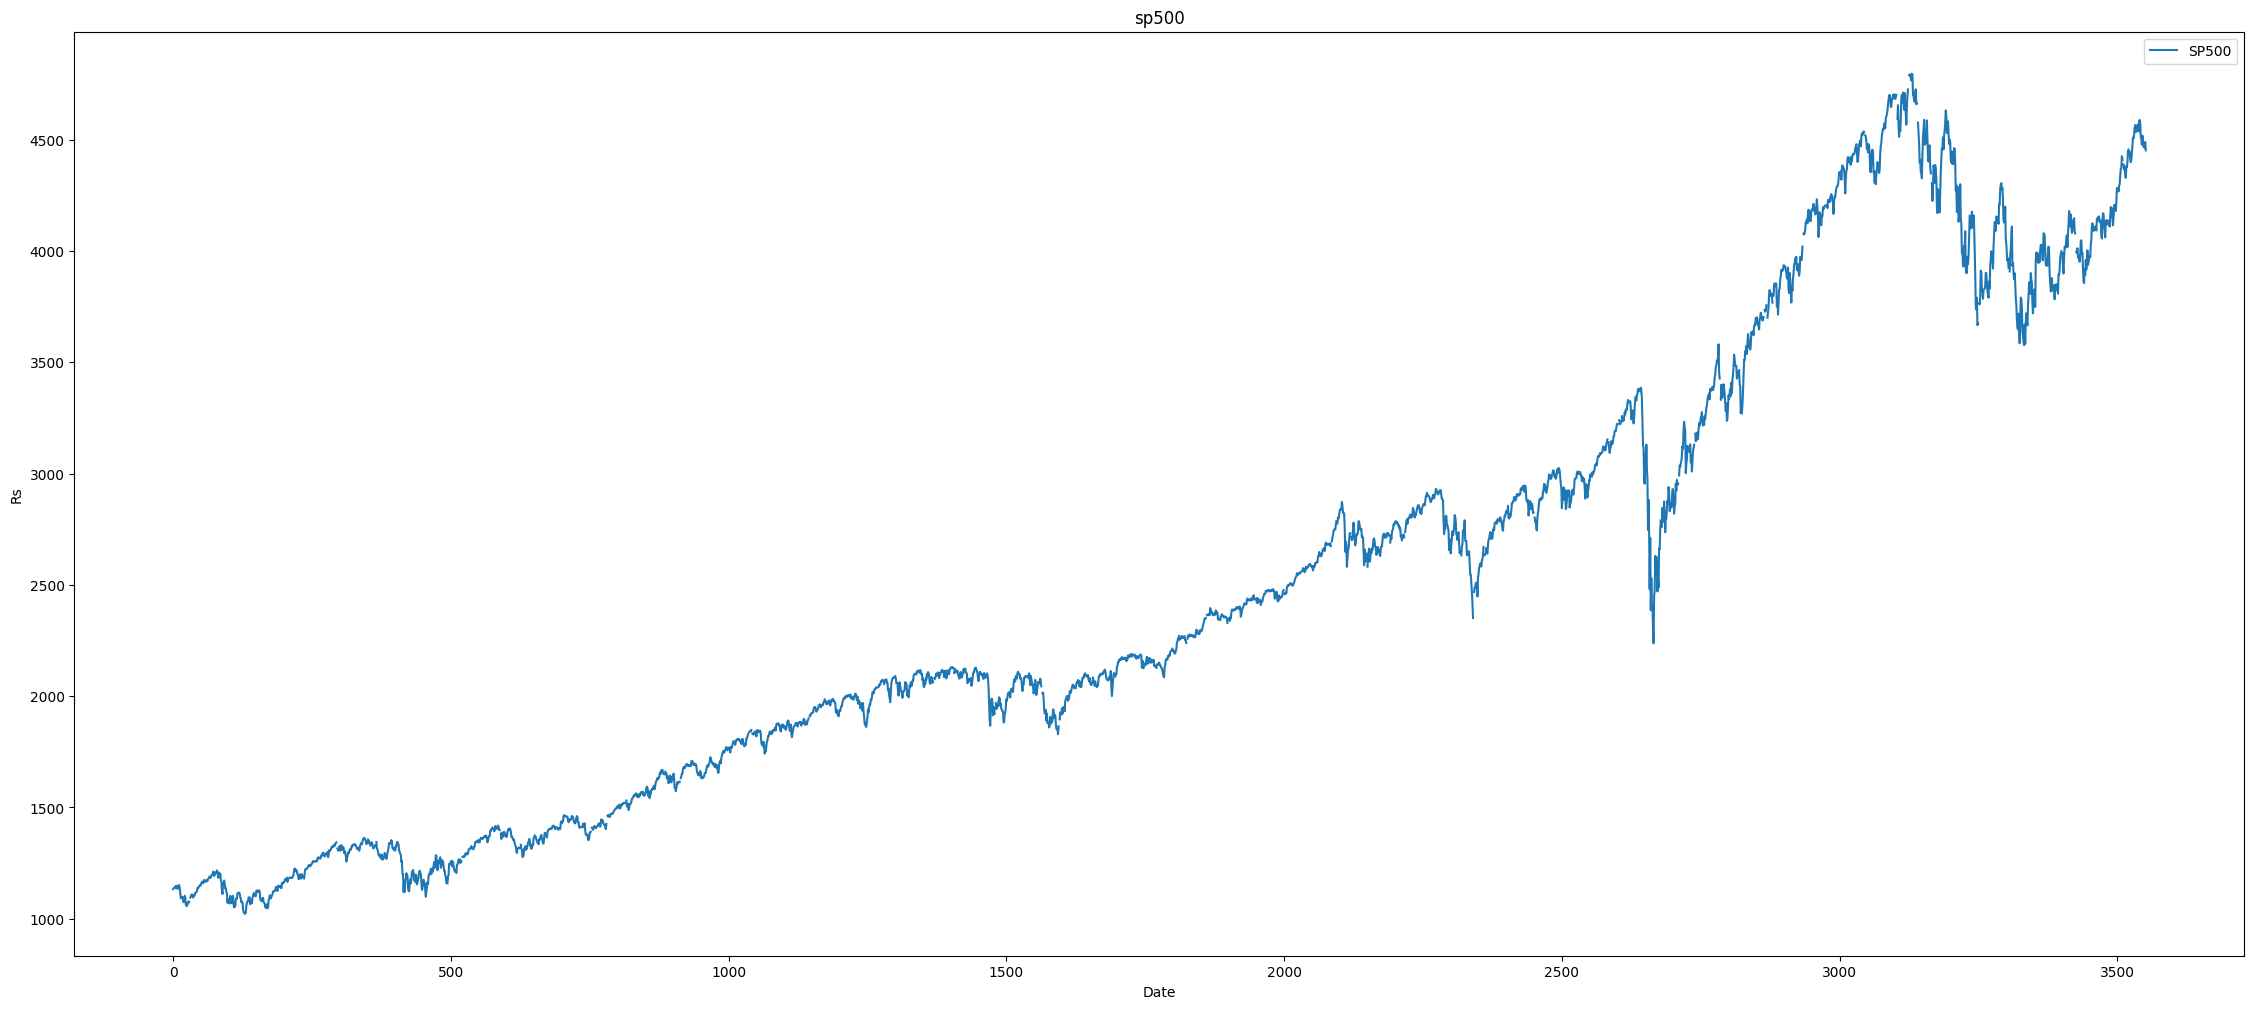

In [36]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Adj Close'], label='SP500')
plt.xlabel('Date')
plt.ylabel('Rs')
plt.title('sp500')
plt.legend()
plt.show()

In [37]:
df = data.copy()
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,BZ=F,DX-Y.NYB,EURUSD=X,GC=F,JPY=X,^DJI,^FTSE,^GDAXI,^GSPC,^IXIC,^N225,^VIX
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,80.120003,77.529999,1.442398,1117.699951,92.495003,10583.959961,5500.299805,6048.299805,1132.989990,2308.419922,10654.790039,20.040001
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,80.589996,77.620003,1.436596,1118.099976,91.584999,10572.019531,5522.500000,6031.859863,1136.520020,2308.709961,10681.830078,19.350000
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,81.889999,77.489998,1.440403,1135.900024,92.356003,10573.679688,5530.000000,6034.330078,1137.140015,2301.090088,10731.450195,19.160000
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,81.510002,77.910004,1.431803,1133.099976,93.389999,10606.860352,5526.700195,6019.359863,1141.689941,2300.050049,10681.660156,19.059999
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,81.370003,77.470001,1.441109,1138.199951,92.660004,10618.190430,5534.200195,6037.609863,1144.979980,2317.169922,10798.320312,18.129999


In [38]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 3095 samples, and 19 features.


# 2. Feature engineering

## 2.1  Features expansion

In [39]:
# Calculate technical indicators
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [45]:
# Getting the Fourier transform features,  applies the Fast Fourier Transform (FFT) on the 'Close' column of
# the input dataset and extracts various Fourier coefficients and their corresponding absolute values and angles,  
# these features can help identify recurring patterns or cyclic behavior in stock prices,
def get_fourier_transfer(dataset):

    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [73]:
# Calculate technical indicators
T_df = get_technical_indicators(df)

In [74]:
T_df.shape

(3095, 27)

In [75]:
T_df = T_df.dropna()
T_df.shape

(3075, 27)

In [76]:
T_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,BZ=F,DX-Y.NYB,EURUSD=X,...,^N225,^VIX,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum
22,2010-02-03,1100.670044,1102.719971,1093.969971,1097.280029,1097.280029,4.285450e+09,75.919998,79.370003,1.390105,...,10404.330078,21.600000,1091.122855,1118.612380,7.069896,25.711726,1170.035832,1067.188929,1097.336610,6.999678
23,2010-02-04,1097.250000,1097.250000,1062.780029,1063.109985,1063.109985,5.859690e+09,72.129997,79.919998,1.374495,...,10355.980469,26.080000,1086.971418,1115.284761,3.649980,28.046576,1171.377914,1059.191608,1074.518860,6.968013
24,2010-02-05,1064.119995,1067.130005,1044.500000,1066.189941,1066.189941,6.438900e+09,69.589996,80.440002,1.368008,...,10057.089844,26.110001,1082.498553,1111.935710,5.925795,29.447445,1170.830599,1053.040821,1068.966248,6.970908
25,2010-02-08,1065.510010,1071.199951,1056.510010,1056.739990,1056.739990,4.089820e+09,70.110001,80.300003,1.365467,...,9951.820312,26.510000,1078.528547,1108.107137,6.629207,30.832490,1169.772116,1046.442158,1060.815409,6.961997
26,2010-02-09,1060.060059,1079.280029,1060.060059,1070.520020,1070.520020,5.114260e+09,72.129997,79.860001,1.378208,...,9932.900391,26.000000,1078.049979,1104.718093,9.046792,30.425162,1165.568417,1043.867770,1067.285149,6.974965


In [77]:
#Get Fourier features
F_df = get_fourier_transfer(T_df)
F_df.head()

,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
0,2707.929059,-0.077331,2574.878398,-0.018339,2707.548185,-0.023562
1,2701.705549,-0.077450,2564.488102,-0.018534,2690.580687,-0.023691
2,2695.481641,-0.077567,2554.103808,-0.018728,2673.592416,-0.023814
3,2689.257435,-0.077681,2543.725946,-0.018921,2656.585450,-0.023930
4,2683.033032,-0.077793,2533.354950,-0.019112,2639.561871,-0.024041


In [97]:
FE_df = pd.concat([T_df, F_df], axis=1)

In [98]:
FE_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,BZ=F,DX-Y.NYB,EURUSD=X,...,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
22,2010-02-03,1100.670044,1102.719971,1093.969971,1097.280029,1097.280029,4.285450e+09,75.919998,79.370003,1.390105,...,1170.035832,1067.188929,1097.336610,6.999678,2571.074986,-0.079377,2348.341542,-0.022282,2332.691365,-0.024758
23,2010-02-04,1097.250000,1097.250000,1062.780029,1063.109985,1063.109985,5.859690e+09,72.129997,79.919998,1.374495,...,1171.377914,1059.191608,1074.518860,6.968013,2564.865992,-0.079440,2338.182605,-0.022440,2315.751800,-0.024719
24,2010-02-05,1064.119995,1067.130005,1044.500000,1066.189941,1066.189941,6.438900e+09,69.589996,80.440002,1.368008,...,1170.830599,1053.040821,1068.966248,6.970908,2558.658817,-0.079500,2328.039090,-0.022596,2298.837732,-0.024671
25,2010-02-08,1065.510010,1071.199951,1056.510010,1056.739990,1056.739990,4.089820e+09,70.110001,80.300003,1.365467,...,1169.772116,1046.442158,1060.815409,6.961997,2552.453563,-0.079558,2317.911418,-0.022750,2281.951256,-0.024613
26,2010-02-09,1060.060059,1079.280029,1060.060059,1070.520020,1070.520020,5.114260e+09,72.129997,79.860001,1.378208,...,1165.568417,1043.867770,1067.285149,6.974965,2546.250330,-0.079613,2307.800010,-0.022902,2265.094461,-0.024546


In [99]:
FE_df.shape

(3494, 33)

In [100]:
FE_df = FE_df.dropna()
FE_df.shape

(2656, 33)

In [101]:
FE_df.set_index('Date', inplace=True)

In [102]:
FE_df.head()

,Open,High,Low,Close,Adj Close,Volume,BZ=F,DX-Y.NYB,EURUSD=X,GC=F,...,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-03,1100.670044,1102.719971,1093.969971,1097.280029,1097.280029,4.285450e+09,75.919998,79.370003,1.390105,1111.400024,...,1170.035832,1067.188929,1097.336610,6.999678,2571.074986,-0.079377,2348.341542,-0.022282,2332.691365,-0.024758
2010-02-04,1097.250000,1097.250000,1062.780029,1063.109985,1063.109985,5.859690e+09,72.129997,79.919998,1.374495,1062.400024,...,1171.377914,1059.191608,1074.518860,6.968013,2564.865992,-0.079440,2338.182605,-0.022440,2315.751800,-0.024719
2010-02-05,1064.119995,1067.130005,1044.500000,1066.189941,1066.189941,6.438900e+09,69.589996,80.440002,1.368008,1052.199951,...,1170.830599,1053.040821,1068.966248,6.970908,2558.658817,-0.079500,2328.039090,-0.022596,2298.837732,-0.024671
2010-02-08,1065.510010,1071.199951,1056.510010,1056.739990,1056.739990,4.089820e+09,70.110001,80.300003,1.365467,1065.699951,...,1169.772116,1046.442158,1060.815409,6.961997,2552.453563,-0.079558,2317.911418,-0.022750,2281.951256,-0.024613
2010-02-09,1060.060059,1079.280029,1060.060059,1070.520020,1070.520020,5.114260e+09,72.129997,79.860001,1.378208,1076.699951,...,1165.568417,1043.867770,1067.285149,6.974965,2546.250330,-0.079613,2307.800010,-0.022902,2265.094461,-0.024546


# 3. Data preparation 

## 3.1. Data split

In [103]:
data_training = FE_df[FE_df.index < '2020-12-31'].copy()
data_training.head()

,Open,High,Low,Close,Adj Close,Volume,BZ=F,DX-Y.NYB,EURUSD=X,GC=F,...,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-03,1100.670044,1102.719971,1093.969971,1097.280029,1097.280029,4.285450e+09,75.919998,79.370003,1.390105,1111.400024,...,1170.035832,1067.188929,1097.336610,6.999678,2571.074986,-0.079377,2348.341542,-0.022282,2332.691365,-0.024758
2010-02-04,1097.250000,1097.250000,1062.780029,1063.109985,1063.109985,5.859690e+09,72.129997,79.919998,1.374495,1062.400024,...,1171.377914,1059.191608,1074.518860,6.968013,2564.865992,-0.079440,2338.182605,-0.022440,2315.751800,-0.024719
2010-02-05,1064.119995,1067.130005,1044.500000,1066.189941,1066.189941,6.438900e+09,69.589996,80.440002,1.368008,1052.199951,...,1170.830599,1053.040821,1068.966248,6.970908,2558.658817,-0.079500,2328.039090,-0.022596,2298.837732,-0.024671
2010-02-08,1065.510010,1071.199951,1056.510010,1056.739990,1056.739990,4.089820e+09,70.110001,80.300003,1.365467,1065.699951,...,1169.772116,1046.442158,1060.815409,6.961997,2552.453563,-0.079558,2317.911418,-0.022750,2281.951256,-0.024613
2010-02-09,1060.060059,1079.280029,1060.060059,1070.520020,1070.520020,5.114260e+09,72.129997,79.860001,1.378208,1076.699951,...,1165.568417,1043.867770,1067.285149,6.974965,2546.250330,-0.079613,2307.800010,-0.022902,2265.094461,-0.024546


In [104]:
data_testing = FE_df[FE_df.index >= '2020-12-31'].copy()
data_testing.head()

,Open,High,Low,Close,Adj Close,Volume,BZ=F,DX-Y.NYB,EURUSD=X,GC=F,...,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5.015000e+09,51.090000,89.879997,1.225070,1944.699951,...,3739.993853,3629.120428,3709.311603,8.215993,3836.879293,-0.023173,4285.985613,0.012418,4146.031193,0.012769
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4.591020e+09,53.599998,89.440002,1.225160,1952.699951,...,3737.735115,3639.808690,3721.010606,8.223053,3832.678673,-0.023504,4281.529172,0.012410,4147.990666,0.012919
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6.064110e+09,54.299999,89.529999,1.230027,1906.900024,...,3747.665177,3641.927201,3739.096797,8.228748,3828.460319,-0.023834,4277.025711,0.012400,4149.940013,0.013064
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5.099160e+09,54.380001,89.830002,1.234111,1912.300049,...,3771.334456,3631.718882,3782.225625,8.243490,3824.224288,-0.024165,4272.475214,0.012388,4151.877631,0.013205
2021-01-08,3815.050049,3826.689941,3783.600098,3824.679932,3824.679932,4.773040e+09,55.990002,90.099998,1.227144,1834.099976,...,3795.196633,3622.682413,3810.528496,8.248969,3819.970637,-0.024495,4267.877671,0.012374,4153.801912,0.013341


In [105]:
data_training.shape, data_testing.shape

((2472, 32), (184, 32))

In [106]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)


(2472, 32)


In [107]:
# window size is 60, nb sample = 1935 (data_training.shape[0]), y_train is price (first colonne, 0)

In [108]:
X_train, y_train = rnn_3D_data(data_training_scaled, window_size=60, y_pos=4)

In [109]:
X_train.shape, y_train.shape

((2412, 60, 32), (2412,))

In [110]:
# add the winodw before test data
data_test = pd.concat([data_training.tail(60), data_testing], ignore_index=True)
data_test_scaled = scalar.fit_transform(data_test)

X_test, y_test = rnn_3D_data(data_test_scaled, window_size=60, y_pos=4)
X_test.shape, y_test.shape

((184, 60, 32), (184,))

In [111]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.5))

#regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
#regressor.add(Dropout(0.3))

#regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressor.add(Dropout(0.4))

#regressor.add(LSTM(units = 120, activation = 'relu'))
#regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [112]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 16,651
Trainable params: 16,651
Non-trainable params: 0
_________________________________________________________________


In [113]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [114]:
history = regressor.fit(X_train, y_train, epochs=50, batch_size = 64,shuffle=False, validation_data=(X_test, y_test),verbose=1) 

Epoch 1/50
38/38 [==============================] - 6s 47ms/step - loss: 0.0320 - val_loss: 0.0227
Epoch 2/50
38/38 [==============================] - 1s 29ms/step - loss: 0.0317 - val_loss: 0.0041
Epoch 3/50
38/38 [==============================] - 1s 27ms/step - loss: 0.0282 - val_loss: 0.0080
Epoch 4/50
38/38 [==============================] - 1s 27ms/step - loss: 0.0174 - val_loss: 0.0042
Epoch 5/50
38/38 [==============================] - 1s 28ms/step - loss: 0.0231 - val_loss: 0.0097
Epoch 6/50
38/38 [==============================] - 1s 28ms/step - loss: 0.0147 - val_loss: 0.0097
Epoch 7/50
38/38 [==============================] - 1s 28ms/step - loss: 0.0158 - val_loss: 0.0091
Epoch 8/50
38/38 [==============================] - 1s 26ms/step - loss: 0.0145 - val_loss: 0.0227
Epoch 9/50
38/38 [==============================] - 1s 27ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 10/50
38/38 [==============================] - 1s 29ms/step - loss: 0.0133 - val_loss: 0.0170
Epoch 11/

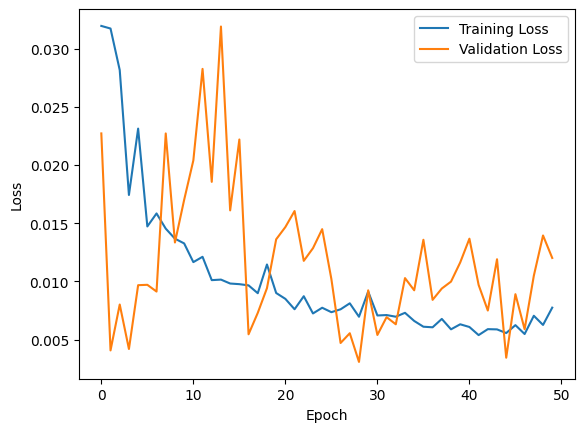

In [115]:
# Plotting training and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.yscale('log')  # Set y-axis to logarithmic scale
plt.legend()
plt.show()


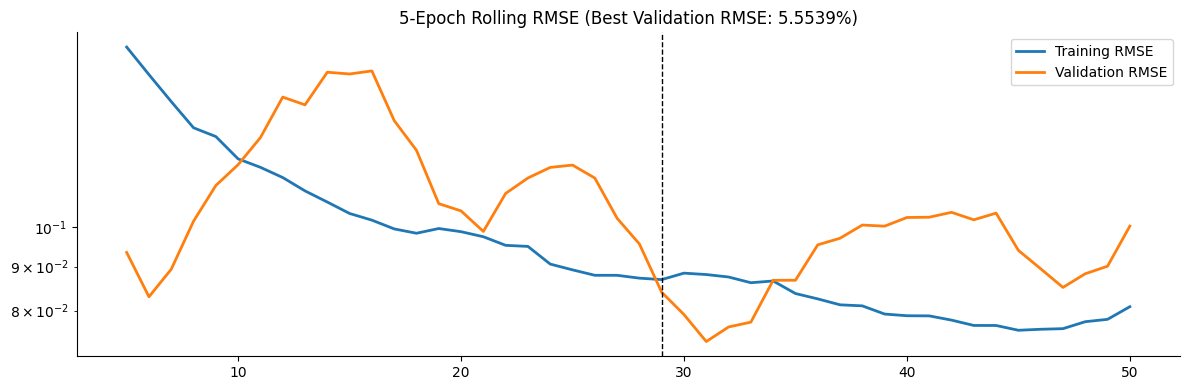

In [116]:
rmse = lstm_mse_rsme(history)

In [117]:
y_pred = regressor.predict(X_test)

6/6 [==============================] - 0s 9ms/step


In [118]:
y_pred[:3]

array([[0.38417894],
       [0.37869123],
       [0.37776545]], dtype=float32)

In [119]:
scale = 1/scalar.scale_[0]

In [120]:
y_pred = y_pred*scale
y_test = y_test*scale

In [121]:
y_pred[:3]

array([[483.37778],
       [476.47308],
       [475.30826]], dtype=float32)

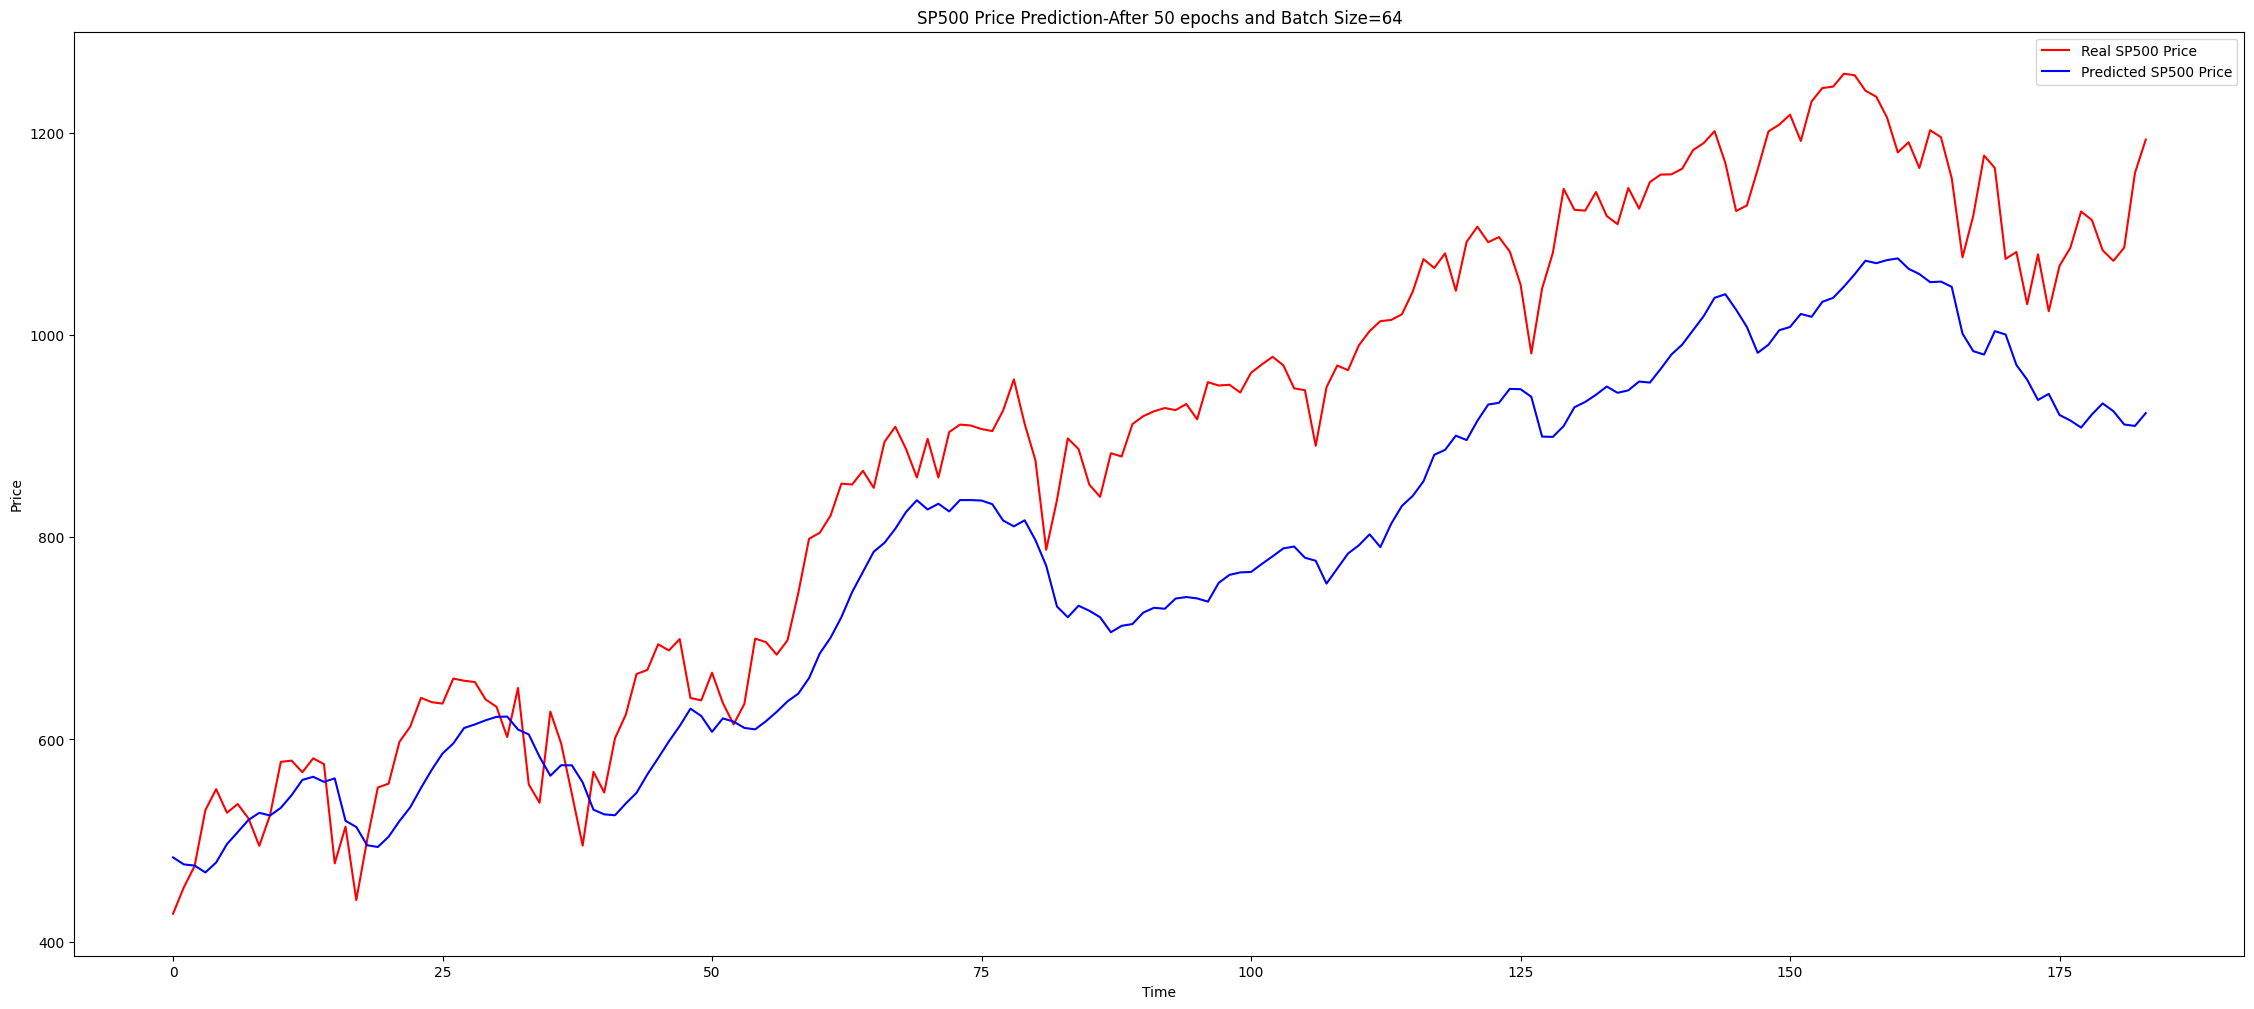

In [122]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real SP500 Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted SP500 Price')
plt.title('SP500 Price Prediction-After 50 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()